In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dr-project/id.csv
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_9865.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_1212.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_5057.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_667.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_6005.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_8577.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_594.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_9416.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_6990.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_1798.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_8743.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_8240.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_4393.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_5564.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_3199.jpeg
/kaggle/input/dr-project/Augmented_Images/DR/DR_0_349.jpeg
/kaggle/inp

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import shutil

2024-04-27 11:31:33.345870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 11:31:33.346036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 11:31:33.503074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.applications.densenet import DenseNet121,DenseNet169

In [4]:
df = pd.read_csv(r'/kaggle/input/dr-project/id.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'DR'
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,DR_0_61,1,DR,DR
1,DR_0_64,1,DR,DR
2,DR_0_81,1,DR,DR
3,DR_0_130,1,DR,DR
4,DR_0_137,1,DR,DR


In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR    247
DR       244
Name: count, dtype: int64 

type
DR       53
No_DR    53
Name: count, dtype: int64 

type
No_DR    53
DR       53
Name: count, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [7]:
# Copy images to respective working directory
src_dir = r'/kaggle/input/dr-project/Augmented_Images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpeg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, batch_size = 32, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, batch_size = 32, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, batch_size = 32, target_size=(224,224), shuffle = False)

Found 491 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [9]:
# Get the DenseNet base model
base_model = DenseNet121(include_top=False, pooling='avg')

# Make the base model untrainable
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint(filepath='model.keras', save_best_only=True)]

In [11]:
history = model.fit(
    train_batches,
    steps_per_epoch = 100,
    validation_data = val_batches, 
    validation_steps = 100,
    epochs = 30)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 16/100 ━━━━━━━━━━━━━━━━━━━━ 4:17 3s/step - accuracy: 0.4341 - loss: 1.0223

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 682ms/step - accuracy: 0.4818 - loss: 0.9033 - val_accuracy: 0.7453 - val_loss: 0.5944
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 663ms/step - accuracy: 0.7763 - loss: 0.5271 - val_accuracy: 0.7642 - val_loss: 0.5366
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 651ms/step - accuracy: 0.8060 - loss: 0.4513 - val_accuracy: 0.7736 - val_loss: 0.4836
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 573ms/step - accuracy: 0.8140 - loss: 0.4121 - val_accuracy: 0.8019 - val_loss: 0.4372
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 577ms/step - accuracy: 0.8292 - loss: 0.3751 - val_accuracy: 0.8019 - val_loss: 0.4063
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 578ms/step - accuracy: 0.8350 - loss: 0.3527 - val_accuracy: 0.8113 - val_loss: 0.3687
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 576ms/step - accuracy: 0.8570 - loss: 0.3059 - val_accuracy: 0.8491 - val_loss: 0.3489
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 664ms/step - accuracy: 0.8846 - loss: 0.2936 - v

In [12]:
loss, accuracy = model.evaluate(val_batches)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8956 - loss: 0.2005
Loss: 0.18021859228610992
Accuracy: 0.9056603908538818


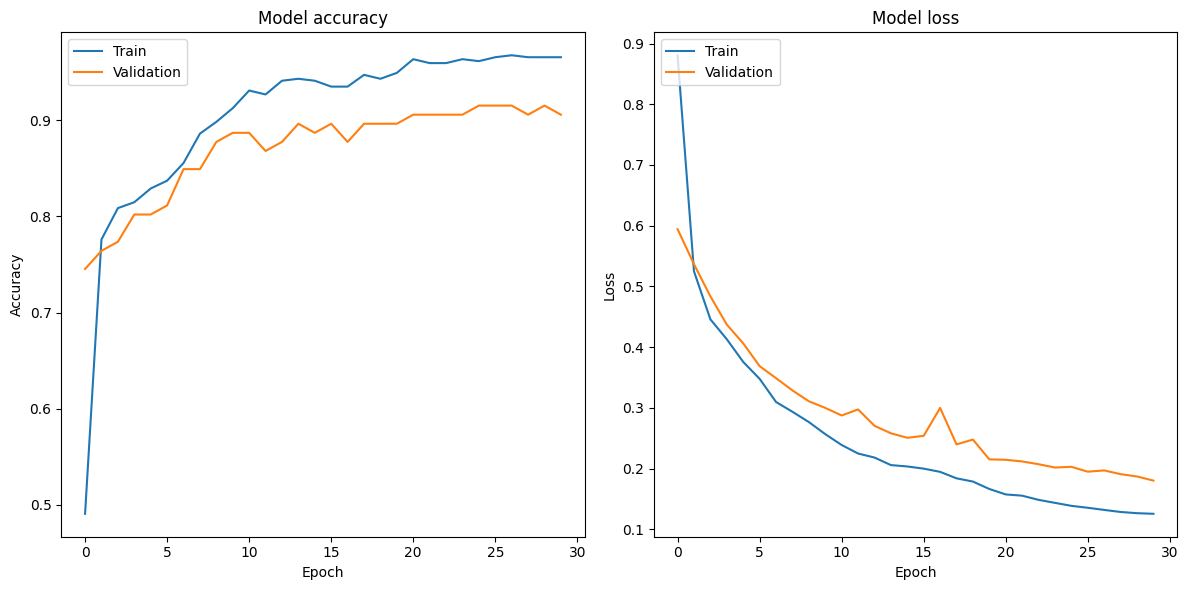

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,656 (26.87 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 4,102 (16.03 KB)

In [15]:
# fname = "weights-DenseNet121-DR.weights.h5"
# model.save_weights(fname, overwrite = True)

In [16]:
# fname = "weights-DenseNet121-DR.weights.h5"
# model.load_weights(fname)

In [17]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    r'/kaggle/working/test', # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

# predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
predictions = (model.predict(test_data_generator) > 0.5).astype("int32")
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 106 images belonging to 2 classes.


/tmp/ipykernel_33/1476124348.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


In [18]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

In [19]:
import sklearn.metrics as metrics

In [20]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

          DR       0.67      0.15      0.25        53
       No_DR       0.52      0.92      0.67        53

    accuracy                           0.54       106
   macro avg       0.59      0.54      0.46       106
weighted avg       0.59      0.54      0.46       106

